In [1]:
# import pip

In [2]:
# pip.main(['install','/datasets/home/34/234/cs291gbl/fastText/. --user'])

In [3]:
import numpy as np
import pip
import torch
from torch import nn
#import fastText
import argparse
from torch.autograd import Variable
import io
from scipy import linalg
# import torch
print(torch.__version__)
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

0.3.1.post3


In [4]:
def load_pretrained_embeddings(path):
    """
    Reload pretrained embeddings from a text file.
    """
    word2id = {}
    vectors = []
    id2word={}
    emb_path =path
    _emb_dim_file = 300
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        for i, line in enumerate(f):
            if i == 0:
                split = line.split()
               
            else:
                word, vect = line.rstrip().split(' ', 1)
                
                word = word.lower()
                vect = np.fromstring(vect, sep=' ')
                if np.linalg.norm(vect) == 0:  # avoid to have null embeddings
                    vect[0] = 0.01
               
                word2id[word] = len(word2id)
                id2word[len(word2id)]=word
                vectors.append(vect[None])
            if len(word2id) >= 200000:
                break

    
    print("Loaded %i pre-trained word embeddings." % len(vectors))


    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.concatenate(vectors, 0)
    embeddings = torch.from_numpy(embeddings).float()
    embeddings = embeddings
    
    return embeddings,word2id,id2word


def load_fasttext_model(path):
    return fastText.load_model(path)

In [5]:
def get_dis_xy(bs, src_emb,tgt_emb):
        """
        Get discriminator input batch / output target.
        """
        # select random word IDs
        #bs = self.params.batch_size
        mf = 75000
        #assert mf <= min(len(self.src_dico), len(self.tgt_dico))
        src_ids = torch.LongTensor(bs).random_(mf)
        tgt_ids = torch.LongTensor(bs).random_(mf)
        
        src_ids = src_ids.cuda()
        tgt_ids = tgt_ids.cuda()

        # get word embeddings
        src_emb = src_emb(Variable(src_ids))
        tgt_emb = tgt_emb(Variable(tgt_ids))
        src_emb = mapping(Variable(src_emb.data))
        tgt_emb = Variable(tgt_emb.data)

        # input / target
        x = torch.cat([src_emb, tgt_emb], 0)
        y = torch.FloatTensor(2 * bs).zero_()
        y[:bs] = 1 - 0.1
        y[bs:] = 0.1
        y = Variable(y.cuda())

        return x, y

In [6]:

# english=load_fasttext_model("data/wiki.en.bin")
# spanish=load_fasttext_model("data/wiki.es.bin")
src_embedding,src_word2id,src_id2word=load_pretrained_embeddings("data/wiki.en.vec")
tgt_embedding,tgt_word2id,tgt_id2word=load_pretrained_embeddings("data/wiki.es.vec")

Loaded 200000 pre-trained word embeddings.
Loaded 200000 pre-trained word embeddings.


In [7]:
src_embeddings = nn.Embedding(200000, 300, sparse=True)
src_embeddings.weight.data.copy_(src_embedding)

tgt_embeddings = nn.Embedding(200000, 300, sparse=True)
tgt_embeddings.weight.data.copy_(tgt_embedding)

src_embeddings.cuda()
tgt_embeddings.cuda()

Embedding(200000, 300, sparse=True)

In [8]:

def get_batch2(X,batch_size):
 
#     N = X.size()[0]
    N=200000
    batch_indices = torch.LongTensor( np.random.randint(0,N,size=batch_size) )

    batch_xs = X(Variable(batch_indices).cuda())

    return batch_xs.cuda()

In [9]:
class Discriminator(nn.Module):

    def __init__(self, dis_hid_dim,dis_dropout,dis_input_dropout):
        super(Discriminator, self).__init__()

        self.emb_dim = 300
        self.dis_layers = 2
        self.dis_hid_dim = dis_hid_dim
        self.dis_dropout = dis_dropout
        self.dis_input_dropout = dis_input_dropout

        layers = [nn.Dropout(self.dis_input_dropout)]
        for i in range(self.dis_layers + 1):
            input_dim = self.emb_dim if i == 0 else self.dis_hid_dim
            output_dim = 1 if i == self.dis_layers else self.dis_hid_dim
            layers.append(nn.Linear(input_dim, output_dim))
            if i < self.dis_layers:
                layers.append(nn.LeakyReLU(0.2))
                layers.append(nn.Dropout(self.dis_dropout))
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        assert x.dim() == 2 and x.size(1) == self.emb_dim
        return self.layers(x).view(-1)

In [10]:

def Orthogonal(mapping,beta):
    W=mapping.weight.data
    mapping.weight.data.copy_((1 + beta) * W - beta * W.mm(W.transpose(0, 1).mm(W)))
    return mapping


In [11]:
#set up linear mapping,
mapping = nn.Linear(300, 300, bias=False)
mapping.weight.data.copy_(torch.eye(300))
modelDisc= Discriminator(2048,0,0.1)
mapping.cuda()
modelDisc.cuda()

Discriminator(
  (layers): Sequential(
    (0): Dropout(p=0.1)
    (1): Linear(in_features=300, out_features=2048, bias=True)
    (2): LeakyReLU(0.2)
    (3): Dropout(p=0)
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): LeakyReLU(0.2)
    (6): Dropout(p=0)
    (7): Linear(in_features=2048, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [12]:
def get_csls(src_emb, tgt_emb, knn=10):
 
    bs = 1024
    all_distances = []
#     emb = tgt_emb.transpose(0, 1).contiguous()
    emb=tgt_emb.transpose(0,1)
    for i in range(0, src_emb.shape[0], bs):
        distances = src_emb[i:i + bs].mm(emb)
        best_distances, _ = distances.topk(knn, dim=1, largest=True, sorted=True)
        all_distances.append(best_distances.mean(1).cpu())
    all_distances = torch.cat(all_distances)
    return all_distances.numpy()

def get_neighbour(emb1,emb2):
    bs = 128

    all_scores = []
    all_targets = []

    # number of source words to consider
    n_src = emb1.size(0)
    n_src =30000
    knn = 10

        # average distances to k nearest neighbors
    average_dist1 = torch.from_numpy(get_csls(emb1, emb2, knn))
    average_dist2 = torch.from_numpy(get_csls(emb2, emb1, knn))
    average_dist1 = average_dist1.type_as(emb1)
    average_dist2 = average_dist2.type_as(emb2)

    # for every source word
    for i in range(0, n_src, bs):

        # compute target words scores
        scores = emb2.mm(emb1[i:min(n_src, i + bs)].transpose(0, 1)).transpose(0, 1)
        scores.mul_(2)
        scores.sub_(average_dist1[i:min(n_src, i + bs)][:, None] + average_dist2[None, :])
        best_scores, best_targets = scores.topk(2, dim=1, largest=True, sorted=True)

        # update scores / potential targets
        all_scores.append(best_scores.cpu())
        all_targets.append(best_targets.cpu())

    all_scores = torch.cat(all_scores, 0)
    all_targets = torch.cat(all_targets, 0)

    all_pairs = torch.cat([torch.arange(0, all_targets.size(0)).long().unsqueeze(1),all_targets[:, 0].unsqueeze(1)], 1)
    assert all_scores.size() == all_pairs.size() == (n_src, 2)

    # sort pairs by score confidence
    diff = all_scores[:, 0] - all_scores[:, 1]
    reordered = diff.sort(0, descending=True)[1]
    all_scores = all_scores[reordered]
    all_pairs = all_pairs[reordered]
    
    
    selected = all_pairs.max(1)[0] <= 30000
    mask = selected.unsqueeze(1).expand_as(all_scores).clone()
    all_scores = all_scores.masked_select(mask).view(-1, 2)
    all_pairs = all_pairs.masked_select(mask).view(-1, 2)
    return all_pairs


In [13]:

def create_dictionary(src_embedding,tgt_embedding):
    src2tgt = get_neighbour(src_embedding,tgt_embedding)
    tgt2src = get_neighbour(tgt_embedding,src_embedding)
    
    s2t_candidates = set([(a, b) for a, b in src2tgt])
    t2s_candidates = set([(a, b) for a, b in tgt2src])
#     print(s2t_candidates)
    final_pairs = s2t_candidates & t2s_candidates
    if len(final_pairs) == 0:
        print("warning")
        return None
    dictionary = torch.LongTensor(list([[a, b] for (a, b) in final_pairs]))

    print('New train dictionary of %i pairs.' % dictionary.size(0))
    return dictionary.cuda()
    
        
# def build_dictionary(src_emb, tgt_emb, _params, s2t_candidates, t2s_candidates):
    

In [14]:
def evaluation_metric(src_embs, tgt_embs):
     
        indices= torch.LongTensor(np.arange(200000))
        batch_xs = src_embs(Variable(indices).cuda())
        src_emb = mapping(batch_xs.cuda())
        src_emb=torch.FloatTensor(src_emb.cpu().data.numpy()).cuda()
        tgt_emb = tgt_embs(Variable(indices).cuda())
        tgt_emb=torch.FloatTensor(tgt_emb.cpu().data.numpy()).cuda()
        src_emb = src_emb / src_emb.norm(2, 1, keepdim=True).expand_as(src_emb)
        tgt_emb = tgt_emb / tgt_emb.norm(2, 1, keepdim=True).expand_as(tgt_emb)
        print(type(src_emb))

#         s2t_candidates = get_candidates(src_emb, tgt_emb, _params)
#         t2s_candidates = get_candidates(tgt_emb, src_emb, _params)
        dictionary = create_dictionary(src_emb, tgt_emb)
        dictionary_max_size = 10000
        if dictionary is None:
            mean_cosine=0
        else:
            mean_cosine = (src_emb[dictionary[:dictionary_max_size, 0]] * tgt_emb[dictionary[:dictionary_max_size, 1]]).sum(1).mean()
        print("Mean cosine", mean_cosine)
        return mean_cosine
            

In [15]:
linoptimizer = torch.optim.SGD(mapping.parameters(), lr=0.1)
discoptimizer= torch.optim.SGD(modelDisc.parameters(), lr=0.1)

loss_fn=torch.nn.BCELoss()

def get_xy():
#get minibatch of spanish words
    spanish_batch=get_batch2(tgt_embeddings,batch_size)
    #getminibatch of english words
    english_batch=get_batch2(src_embeddings,batch_size)

    #generate fake spanish embeddings
    s_fake= mapping(english_batch)

    #stack real and fake
    x = torch.cat([s_fake, spanish_batch], 0)
    #         print(x.shape)
    y = torch.FloatTensor(2 * batch_size).zero_()
    
    y[batch_size:] = 0.1
    y[:batch_size]=1-0.1
    y=Variable(y).cuda()
    return x,y

In [16]:
iterations_per_epoch=1000000
batch_size=32
epoch=5
val_score=-1

for _ in range(epoch):
      
    for _n in range(0,iterations_per_epoch,batch_size):
        modelDisc.train()
        mapping.eval()
        for __ in range(5):

            #x,y=get_xy()
            x,y=get_dis_xy(32,src_embeddings,tgt_embeddings)
            y_pred = modelDisc(Variable(x.data))
       


            loss= loss_fn(y_pred, y)

            discoptimizer.zero_grad()


       
            loss.backward()
    #         print(loss.data)

           
            discoptimizer.step()
          
        modelDisc.eval()
        mapping.train()
        for __ in range(3):
            
            #x,y=get_xy()
            x,y=get_dis_xy(32,src_embeddings,tgt_embeddings)
            y=1-y
            y_pred = modelDisc(x)
            loss2= loss_fn(y_pred, y)
            linoptimizer.zero_grad()
            loss2.backward()
            linoptimizer.step()

            mapping=Orthogonal(mapping,0.001)
        if _n%500==0:
            print(torch.norm(mapping.weight.data,2))
            print(_n," Discriminator Loss :  ",loss.data)
            print("Generator Loss : ", loss2.data)
        
    val=evaluation_metric(src_embeddings,tgt_embeddings)
    if val_score<val:
        torch.save(mapping.state_dict(), './mapping.pth')
        val_score=val
    

    
    

17.3200645447
(0, ' Discriminator Loss :  ', 
 0.6561
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 0.7376
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
17.1370391846
(4000, ' Discriminator Loss :  ', 
 0.5397
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 0.8969
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.8056850433
(8000, ' Discriminator Loss :  ', 
 0.6164
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 0.9241
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.6027240753
(12000, ' Discriminator Loss :  ', 
 0.5819
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 0.9578
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.4151935577
(16000, ' Discriminator Loss :  ', 
 0.5429
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 0.9575
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.2775611877
(20000, ' Discriminator Loss :  ', 
 0.5554
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Genera

16.4117641449
(184000, ' Discriminator Loss :  ', 
 0.4312
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.7578
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.393945694
(188000, ' Discriminator Loss :  ', 
 0.4555
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.6864
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.4219264984
(192000, ' Discriminator Loss :  ', 
 0.4154
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.6991
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.464466095
(196000, ' Discriminator Loss :  ', 
 0.4420
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.6967
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.4867095947
(200000, ' Discriminator Loss :  ', 
 0.4421
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.5592
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.5307979584
(204000, ' Discriminator Loss :  ', 
 0.4266
[torch.cuda.FloatTensor of size 1 (GPU 0)]


16.7264957428
(368000, ' Discriminator Loss :  ', 
 0.4596
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.7636
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.7325172424
(372000, ' Discriminator Loss :  ', 
 0.4556
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.5780
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.7404918671
(376000, ' Discriminator Loss :  ', 
 0.4430
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.5324
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.7203330994
(380000, ' Discriminator Loss :  ', 
 0.4428
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.6503
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.7229042053
(384000, ' Discriminator Loss :  ', 
 0.4525
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.6706
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.7642097473
(388000, ' Discriminator Loss :  ', 
 0.4404
[torch.cuda.FloatTensor of size 1 (GPU 0)

16.6457386017
(552000, ' Discriminator Loss :  ', 
 0.4221
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.8740
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.6044025421
(556000, ' Discriminator Loss :  ', 
 0.4158
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.8971
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.6654319763
(560000, ' Discriminator Loss :  ', 
 0.4070
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.8084
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.6183795929
(564000, ' Discriminator Loss :  ', 
 0.4352
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.5559
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.5906677246
(568000, ' Discriminator Loss :  ', 
 0.4070
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.8452
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.6173553467
(572000, ' Discriminator Loss :  ', 
 0.4141
[torch.cuda.FloatTensor of size 1 (GPU 0)

16.3056697845
(736000, ' Discriminator Loss :  ', 
 0.4167
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1878
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.3116436005
(740000, ' Discriminator Loss :  ', 
 0.3835
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9504
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.3080558777
(744000, ' Discriminator Loss :  ', 
 0.3948
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9991
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.3033123016
(748000, ' Discriminator Loss :  ', 
 0.3699
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9766
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.2871246338
(752000, ' Discriminator Loss :  ', 
 0.4496
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1188
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.2757701874
(756000, ' Discriminator Loss :  ', 
 0.3985
[torch.cuda.FloatTensor of size 1 (GPU 0)

16.180065155
(920000, ' Discriminator Loss :  ', 
 0.3752
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9915
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1631565094
(924000, ' Discriminator Loss :  ', 
 0.3794
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0550
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1385250092
(928000, ' Discriminator Loss :  ', 
 0.3837
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.8969
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1052799225
(932000, ' Discriminator Loss :  ', 
 0.3802
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9362
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1472530365
(936000, ' Discriminator Loss :  ', 
 0.4063
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0692
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1538696289
(940000, ' Discriminator Loss :  ', 
 0.3891
[torch.cuda.FloatTensor of size 1 (GPU 0)]

16.1172809601
(104000, ' Discriminator Loss :  ', 
 0.3836
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.8783
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1232700348
(108000, ' Discriminator Loss :  ', 
 0.3771
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9227
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1427364349
(112000, ' Discriminator Loss :  ', 
 0.3970
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9193
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1480903625
(116000, ' Discriminator Loss :  ', 
 0.4197
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.8191
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.164270401
(120000, ' Discriminator Loss :  ', 
 0.4001
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9222
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1508388519
(124000, ' Discriminator Loss :  ', 
 0.3908
[torch.cuda.FloatTensor of size 1 (GPU 0)]

16.2006187439
(288000, ' Discriminator Loss :  ', 
 0.3684
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9229
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.167552948
(292000, ' Discriminator Loss :  ', 
 0.3983
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9341
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1430683136
(296000, ' Discriminator Loss :  ', 
 0.3836
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0461
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1143798828
(300000, ' Discriminator Loss :  ', 
 0.3740
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0388
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1038780212
(304000, ' Discriminator Loss :  ', 
 0.3882
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0873
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.0867767334
(308000, ' Discriminator Loss :  ', 
 0.3924
[torch.cuda.FloatTensor of size 1 (GPU 0)]

16.0723304749
(472000, ' Discriminator Loss :  ', 
 0.3857
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2408
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1036529541
(476000, ' Discriminator Loss :  ', 
 0.3868
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.8875
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1411018372
(480000, ' Discriminator Loss :  ', 
 0.3680
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2073
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1292228699
(484000, ' Discriminator Loss :  ', 
 0.3696
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3306
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1548576355
(488000, ' Discriminator Loss :  ', 
 0.3923
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1340
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1893482208
(492000, ' Discriminator Loss :  ', 
 0.3668
[torch.cuda.FloatTensor of size 1 (GPU 0)

16.3699836731
(656000, ' Discriminator Loss :  ', 
 0.3609
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0912
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.3611812592
(660000, ' Discriminator Loss :  ', 
 0.3741
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1345
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.3938350677
(664000, ' Discriminator Loss :  ', 
 0.3752
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0675
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.3953170776
(668000, ' Discriminator Loss :  ', 
 0.3705
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9016
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.411781311
(672000, ' Discriminator Loss :  ', 
 0.3674
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9999
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.384475708
(676000, ' Discriminator Loss :  ', 
 0.3819
[torch.cuda.FloatTensor of size 1 (GPU 0)]


16.2547721863
(840000, ' Discriminator Loss :  ', 
 0.3764
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0246
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.2805461884
(844000, ' Discriminator Loss :  ', 
 0.3755
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0716
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.2141151428
(848000, ' Discriminator Loss :  ', 
 0.4063
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9776
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1658725739
(852000, ' Discriminator Loss :  ', 
 0.3663
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9650
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.129152298
(856000, ' Discriminator Loss :  ', 
 0.3791
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 1.9639
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.1160545349
(860000, ' Discriminator Loss :  ', 
 0.3628
[torch.cuda.FloatTensor of size 1 (GPU 0)]

15.8256111145
(24000, ' Discriminator Loss :  ', 
 0.3931
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1075
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8193016052
(28000, ' Discriminator Loss :  ', 
 0.3983
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2488
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.7974710464
(32000, ' Discriminator Loss :  ', 
 0.3549
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1840
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.848613739
(36000, ' Discriminator Loss :  ', 
 0.3563
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2596
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8384523392
(40000, ' Discriminator Loss :  ', 
 0.4060
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0606
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8449888229
(44000, ' Discriminator Loss :  ', 
 0.3844
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('G

16.0770683289
(208000, ' Discriminator Loss :  ', 
 0.3619
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1400
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.0972442627
(212000, ' Discriminator Loss :  ', 
 0.3668
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1757
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.0518321991
(216000, ' Discriminator Loss :  ', 
 0.3654
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2168
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.0692253113
(220000, ' Discriminator Loss :  ', 
 0.3602
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3052
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.0574188232
(224000, ' Discriminator Loss :  ', 
 0.3836
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2602
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.0809135437
(228000, ' Discriminator Loss :  ', 
 0.3715
[torch.cuda.FloatTensor of size 1 (GPU 0)

15.8745555878
(392000, ' Discriminator Loss :  ', 
 0.3767
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1360
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.831328392
(396000, ' Discriminator Loss :  ', 
 0.3570
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2254
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8373947144
(400000, ' Discriminator Loss :  ', 
 0.3695
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1481
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8588600159
(404000, ' Discriminator Loss :  ', 
 0.3471
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2607
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8347196579
(408000, ' Discriminator Loss :  ', 
 0.3573
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2271
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8551063538
(412000, ' Discriminator Loss :  ', 
 0.3661
[torch.cuda.FloatTensor of size 1 (GPU 0)]

15.673871994
(576000, ' Discriminator Loss :  ', 
 0.4006
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1025
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.645942688
(580000, ' Discriminator Loss :  ', 
 0.3715
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1506
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.6020002365
(584000, ' Discriminator Loss :  ', 
 0.3642
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1033
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.6149930954
(588000, ' Discriminator Loss :  ', 
 0.3801
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0172
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.6608200073
(592000, ' Discriminator Loss :  ', 
 0.3570
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0935
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.6809453964
(596000, ' Discriminator Loss :  ', 
 0.3681
[torch.cuda.FloatTensor of size 1 (GPU 0)]


15.5764627457
(760000, ' Discriminator Loss :  ', 
 0.3607
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3056
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.5566883087
(764000, ' Discriminator Loss :  ', 
 0.3845
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3411
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.5209589005
(768000, ' Discriminator Loss :  ', 
 0.3729
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2651
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.4536399841
(772000, ' Discriminator Loss :  ', 
 0.3791
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0424
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.3768730164
(776000, ' Discriminator Loss :  ', 
 0.3843
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2769
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.2615404129
(780000, ' Discriminator Loss :  ', 
 0.3805
[torch.cuda.FloatTensor of size 1 (GPU 0)

15.9250411987
(944000, ' Discriminator Loss :  ', 
 0.3588
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.0126
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.9953632355
(948000, ' Discriminator Loss :  ', 
 0.3721
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3530
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.9440517426
(952000, ' Discriminator Loss :  ', 
 0.3603
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2462
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.9887104034
(956000, ' Discriminator Loss :  ', 
 0.3605
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2300
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.9913225174
(960000, ' Discriminator Loss :  ', 
 0.3562
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1794
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.9778079987
(964000, ' Discriminator Loss :  ', 
 0.3564
[torch.cuda.FloatTensor of size 1 (GPU 0)

15.9704427719
(128000, ' Discriminator Loss :  ', 
 0.3624
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3295
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.9230871201
(132000, ' Discriminator Loss :  ', 
 0.3557
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2949
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8979616165
(136000, ' Discriminator Loss :  ', 
 0.3752
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2485
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8238039017
(140000, ' Discriminator Loss :  ', 
 0.3506
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1862
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.7303209305
(144000, ' Discriminator Loss :  ', 
 0.3771
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2104
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.7086877823
(148000, ' Discriminator Loss :  ', 
 0.3655
[torch.cuda.FloatTensor of size 1 (GPU 0)

16.0475349426
(572000, ' Discriminator Loss :  ', 
 0.3783
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1252
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.0142993927
(576000, ' Discriminator Loss :  ', 
 0.3532
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1510
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.0499038696
(580000, ' Discriminator Loss :  ', 
 0.3749
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1600
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.0390434265
(584000, ' Discriminator Loss :  ', 
 0.3647
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3356
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.0099411011
(588000, ' Discriminator Loss :  ', 
 0.3673
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1723
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
16.0268764496
(592000, ' Discriminator Loss :  ', 
 0.3557
[torch.cuda.FloatTensor of size 1 (GPU 0)

15.8143577576
(756000, ' Discriminator Loss :  ', 
 0.3915
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3925
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8119697571
(760000, ' Discriminator Loss :  ', 
 0.3615
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3043
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8273363113
(764000, ' Discriminator Loss :  ', 
 0.3787
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3149
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8507795334
(768000, ' Discriminator Loss :  ', 
 0.3575
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1235
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8660593033
(772000, ' Discriminator Loss :  ', 
 0.3698
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2752
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.7705669403
(776000, ' Discriminator Loss :  ', 
 0.3656
[torch.cuda.FloatTensor of size 1 (GPU 0)

15.9197483063
(940000, ' Discriminator Loss :  ', 
 0.3521
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2312
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.9178724289
(944000, ' Discriminator Loss :  ', 
 0.3494
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1153
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.9287872314
(948000, ' Discriminator Loss :  ', 
 0.3681
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3306
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8874464035
(952000, ' Discriminator Loss :  ', 
 0.3537
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2621
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.8430366516
(956000, ' Discriminator Loss :  ', 
 0.3624
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1030
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.9032526016
(960000, ' Discriminator Loss :  ', 
 0.3543
[torch.cuda.FloatTensor of size 1 (GPU 0)

15.6190404892
(124000, ' Discriminator Loss :  ', 
 0.3759
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.4163
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.6360349655
(128000, ' Discriminator Loss :  ', 
 0.3507
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.4116
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.6514883041
(132000, ' Discriminator Loss :  ', 
 0.3626
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2682
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.6811752319
(136000, ' Discriminator Loss :  ', 
 0.3619
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3667
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.7517728806
(140000, ' Discriminator Loss :  ', 
 0.3772
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.5281
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.7581958771
(144000, ' Discriminator Loss :  ', 
 0.3606
[torch.cuda.FloatTensor of size 1 (GPU 0)

15.7186994553
(308000, ' Discriminator Loss :  ', 
 0.3527
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3477
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.6989936829
(312000, ' Discriminator Loss :  ', 
 0.3755
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2119
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.7560853958
(316000, ' Discriminator Loss :  ', 
 0.3470
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2681
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.750790596
(320000, ' Discriminator Loss :  ', 
 0.3609
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3409
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.7772245407
(324000, ' Discriminator Loss :  ', 
 0.3545
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1603
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.7295417786
(328000, ' Discriminator Loss :  ', 
 0.3532
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13.1957578659
(492000, ' Discriminator Loss :  ', 
 0.3699
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2537
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
13.2816610336
(496000, ' Discriminator Loss :  ', 
 0.3583
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3465
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
13.3321552277
(500000, ' Discriminator Loss :  ', 
 0.3762
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1731
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
13.3618240356
(504000, ' Discriminator Loss :  ', 
 0.3585
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2211
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
13.4585342407
(508000, ' Discriminator Loss :  ', 
 0.3796
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.3194
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
13.4721593857
(512000, ' Discriminator Loss :  ', 
 0.3578
[torch.cuda.FloatTensor of size 1 (GPU 0)

15.0951700211
(676000, ' Discriminator Loss :  ', 
 0.3587
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1576
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.0835819244
(680000, ' Discriminator Loss :  ', 
 0.3806
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2063
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.1252202988
(684000, ' Discriminator Loss :  ', 
 0.3616
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1665
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.1102705002
(688000, ' Discriminator Loss :  ', 
 0.3667
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1553
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.0739183426
(692000, ' Discriminator Loss :  ', 
 0.3469
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1842
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
15.144361496
(696000, ' Discriminator Loss :  ', 
 0.3477
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13.2120494843
(860000, ' Discriminator Loss :  ', 
 0.3616
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.1576
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
13.0137166977
(864000, ' Discriminator Loss :  ', 
 0.3608
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2557
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
12.868806839
(868000, ' Discriminator Loss :  ', 
 0.3649
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2346
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
12.8374385834
(872000, ' Discriminator Loss :  ', 
 0.3625
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2127
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
12.7807130814
(876000, ' Discriminator Loss :  ', 
 0.3532
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
('Generator Loss : ', 
 2.2782
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)
12.7547607422
(880000, ' Discriminator Loss :  ', 
 0.3549
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [17]:
def build_dictionary(src_emb,tgt_emb):
    src_emb = mapping(Variable(src_emb, requires_grad=False).cuda())
    src_emb=torch.FloatTensor(src_emb.cpu().data.numpy()).cuda()
    tgt_emb = tgt_emb.cuda()
    src_emb = src_emb / src_emb.norm(2, 1, keepdim=True).expand_as(src_emb)
    tgt_emb = tgt_emb / tgt_emb.norm(2, 1, keepdim=True).expand_as(tgt_emb)


#         s2t_candidates = get_candidates(src_emb, tgt_emb, _params)
#         t2s_candidates = get_candidates(tgt_emb, src_emb, _params)
    dictionary= create_dictionary(src_emb, tgt_emb)
    return dictionary

dictionary=build_dictionary(src_embedding,tgt_embedding)

    

warning


In [18]:
def procrustes(src_emb,tgt_emb):
    A = src_emb[dictionary[:, 0]]
    B = tgt_emb[dictionary[:, 1]]
    M = B.transpose(0, 1).mm(A).cpu().numpy()
    U, S, V_t = linalg.svd(M, full_matrices=True)
    mapping.weight.data.copy_(torch.from_numpy(U.dot(V_t)).type_as(W))


In [19]:
# for i in range(5):
#     procrustes(src_embeddings,tgt_embeddings)
#     evaluation_metric(src_embeddings,tgt_embeddings)
#     val=evaluation_metric(src_embeddings,tgt_embeddings)
#     if val_score<val:
#         torch.save(mapping.state_dict(), './mapping.pth')
    

In [20]:
# # spanish_embeddings
# tgt_emb2=tgt_embeddings.cpu().numpy()
# # print(tgt_emd.shape)


# def get_nn(word_emb, tgt_emb, tgt_id2word, K=5):
  
#     scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
#     k_best = scores.argsort()[-K:][::-1]
#     for i, idx in enumerate(k_best):
#         print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [21]:
# def create_map(words,language):
#     id2word={}
#     for word in words:
#         id=language.get_word_id(word)
#         id2word[id]=word
#     return id2word
# spanish_map=create_map(Swords,spanish)
        

In [22]:
# cat_embedding=mapping(Variable(src_embeddings[src_word2id['same']],requires_grad=False).cuda()).cpu().data
# word_emd=cat_embedding.numpy()
# get_nn(word_emd,tgt_emb,tgt_id2word)


In [23]:
# cat_embedding=tgt_embeddings[tgt_word2id['misma']]
# word_emd=cat_embedding.numpy()
# get_nn(word_emd,fake_src_embeddings.cpu().numpy(),src_id2word)


In [24]:
fake_src_embeddings=(mapping(Variable(src_embedding, requires_grad=False).cuda())).cuda()
# tgt_embeddings=(tgt_embeddings).cuda()

In [25]:
fake_src_embeddings=torch.FloatTensor(fake_src_embeddings.cpu().data.numpy())
# # type(fake_src_embeddings)
# # src_embedding=src_embeddings.cpu().detach().numpy()
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([fake_src_embeddings, tgt_embedding]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())
# src_emb=fake_src_embeddings/fake_src_embeddings.norm(2, 1, keepdim=True).expand_as(fake_src_embeddings)
# tgt_emb = tgt_embeddings / tgt_embeddings.norm(2, 1, keepdim=True).expand_as(tgt_embeddings)

Variance explained: 0.07


In [26]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()
    

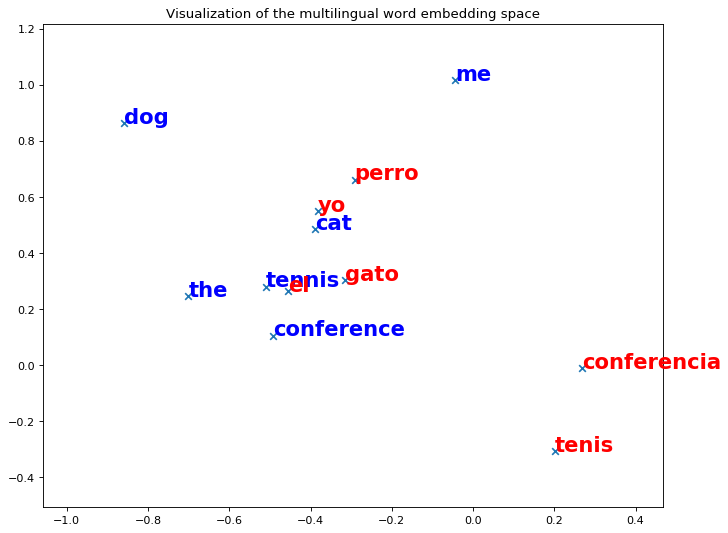

In [27]:
src_words = ['dog', 'the', 'me', 'tennis', 'cat', 'conference']
tgt_words = ['perro', 'el', 'yo', u'tenis',  'gato', 'conferencia']

plot_similar_word(src_words,src_word2id,fake_src_embeddings.cpu().numpy(),tgt_words,tgt_word2id,tgt_embedding.cpu().numpy(),pca)
# # english.get_word_id

In [28]:
# dico=create_dictionary(src_emb,tgt_emb)
# print(type(src_embedding))

In [29]:
# fake_src_embeddings2=(mapping(Variable(src_embeddings, requires_grad=False).cuda())).cuda()

In [30]:
# cat_embedding=mapping(Variable(src_embeddings[src_word2id['the']],requires_grad=False).cuda()).cpu().data
# word_emd=cat_embedding.numpy()
# get_nn(word_emd,tgt_embeddings.cpu().numpy(),tgt_id2word)